<a href="https://colab.research.google.com/github/mursune/TFM_malaria/blob/main/code_TFM_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TFM - Anna Mur Suñé**

# Libraries and Mount Google Drive

In [ ]:
# Import the necessary libraries

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.patches as patches
import cv2
#import torch
import shutil
import pandas as pd
!pip install supervision
import supervision as sv

import skimage
from skimage import io, feature, measure, exposure, color, morphology
from skimage.measure import regionprops, label, shannon_entropy
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import entropy, skew, kurtosis

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.8 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive (where the images are)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Annotation visualization

Annotation was carried out using LabelStudio. The results were exported as COCO annotation. There is a folder with a json file and all the original images

**COCO annotation**

In [ ]:
# Path to COCO annotation JSON file (obtained with Label Studio)
path_json = '/content/drive/MyDrive/data/malaria_COCO/result.json'

# Directory of original images
directory_images = '/content/drive/MyDrive/data/malaria_COCO/images/'

# Initialize COCO api to load JSON file
coco = COCO(path_json)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


**Categories**

There are images from two different categories: infected and uninfected

In [ ]:
# Get the categories in the COCO dataset (in this case: infected and uninfected)
cats = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in cats]
print('Categories:', ', '.join(category_names))

# Define the colors of each category
category_colors = {'infected': 'r', 'uninfected': 'b'}

Categories: infected, uninfected


**Annotation visualization**

The annotations previously done in LabelStudio can be visualized in Google Colab. Bounding boxes and labels are shown in the original images

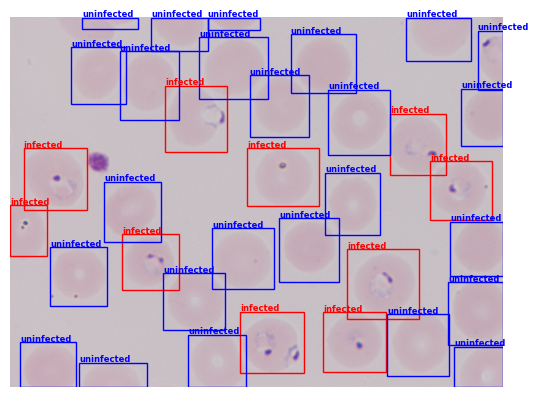

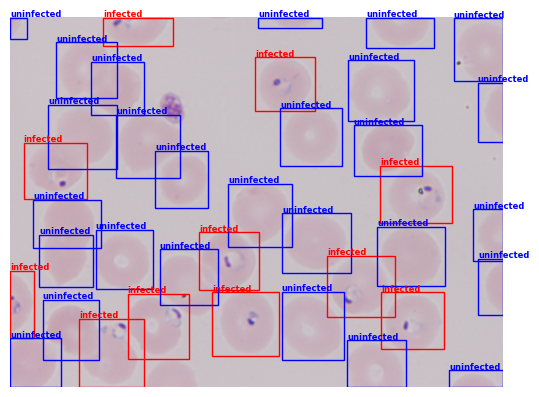

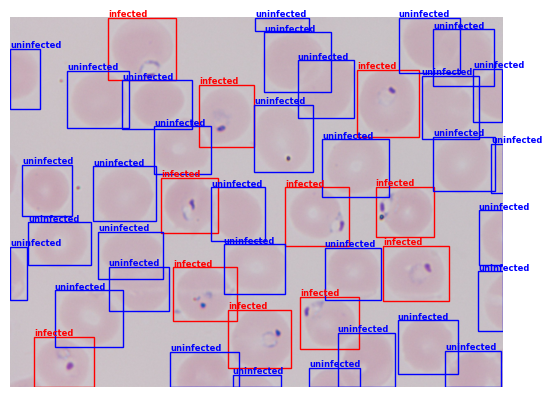

In [ ]:
# Get image IDs
ids_images = coco.getImgIds()

# View some images and their annotations
num_images_show = 3

for id_image in ids_images[:num_images_show]:

    # Load image information and annotations
    info_image = coco.loadImgs(id_image)[0]
    annotations_ids = coco.getAnnIds(imgIds=id_image)
    annotations = coco.loadAnns(annotations_ids)

    # Read and show the image
    path_image = directory_images + info_image['file_name']
    image = Image.open(path_image)
    plt.imshow(image)
    plt.axis('off')

    # Draw the bounding boxes and label them on the image
    for ann in annotations:
        bbox = ann['bbox']
        category_id = ann['category_id']
        category_name = coco.loadCats(category_id)[0]['name']
        color = category_colors.get(category_name)

        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # Convert from (x, y, w, h) to (x_min, y_min, x_max, y_max)
        rect = patches.Rectangle((bbox[0], bbox[1]), (bbox[2]-bbox[0]), (bbox[3]-bbox[1]), linewidth=1, edgecolor= color, facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(bbox[0], bbox[1]-5, category_name, color=color, fontsize=6, weight='bold')

    plt.show()

# Segment Anything Model

In [ ]:
# Install SAM
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
from segment_anything import sam_model_registry, SamPredictor

  Preparing metadata (setup.py) ... done


In [ ]:
# Download SAM weights
home = os.getcwd()
!mkdir -p {home}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {home}/weights

checkpoint_path = os.path.join(home, "weights", "sam_vit_h_4b8939.pth")
print(checkpoint_path, "; exist:", os.path.isfile(checkpoint_path))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
# Load SAM
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device=device)
mask_predictor = SamPredictor(sam)

In [ ]:
# USED FOR SEGMENTATION

num_images_show = 331

for id_image in ids_images[:num_images_show]:

    # Load image information and annotations
    info_image = coco.loadImgs(id_image)[0]
    anotations_ids = coco.getAnnIds(imgIds=id_image)
    annotations = coco.loadAnns(anotations_ids)

    # Path of the image
    path_image = directory_images + info_image['file_name']

    # Convert BGR to RGB
    image_bgr = cv2.imread(path_image)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Obtain the bounding boxes
    for ann in annotations:
        bbox = ann['bbox']
        # The bounding box format for the SAM model should be in the form of [x_min, y_min, x_max, y_max]
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # Convert from [x, y, w, h] to [x_min, y_min, x_max, y_max]
        bbox = np.array(bbox)

        # Category of the cell
        category_id = ann['category_id']
        category_name = coco.loadCats(category_id)[0]['name']

        # Set name of images as 'patient_01_01_num_category' to save orderly
        image_name_save = info_image['file_name']
        image_name_save = image_name_save.replace(".jpg", "") # remove .jpg extension
        image_name_save = image_name_save[9:] # remove image name from the beggining
        image_name_save = image_name_save + '_' + str(ann['id']) + '_' + category_name # add annotation id and category
        print(image_name_save)

        # Segmentation with Bounding Box
        mask_predictor.set_image(image_rgb)
        masks, scores, logits = mask_predictor.predict(box=bbox, multimask_output=True) # use multimask_output=True to obtain 3 masks

        for i, (mask, score) in enumerate(zip(masks, scores)):
            mask = masks[np.argmax(scores)].astype(int) # from the three masks, choose the best mask (the one with highest score)

        # Save masks
        mask_trans = np.moveaxis(mask, 0, 1) # change channels first (channel, width, height) to channels last format (width, height, channel)
        mask_image = (mask * 255).astype(np.uint8) # Convert to uint8 format
        directory_save_masks = '/content/drive/MyDrive/data/best_masks/'
        cv2.imwrite(os.path.join(directory_save_masks, image_name_save + '_mask.jpg'), mask_image) # save masks

        # Obtain and save masked images
        masked_image = cv2.bitwise_and(image_bgr, image_bgr, mask=mask_image)
        #directory_save_masked_images = '/content/drive/MyDrive/data/masked_images/'
        #cv2.imwrite(os.path.join(directory_save_masked_images, image_name_save + '_masked.jpg'), masked_image) # save masked images

        # Crop RBC and save cell images
        (x, y, w, h) = cv2.boundingRect(mask_image) # Get coordinates of minimum enclosing rectangle
        cell_image = masked_image[y:y+h, x:x+w] # Crop image to object area
        directory_save_cell_images = '/content/drive/MyDrive/data/cell_images/'
        cv2.imwrite(os.path.join(directory_save_cell_images, image_name_save + '_RBC.jpg'), cell_image) # save cut RBC images

Se han truncado las últimas 5000 líneas del flujo de salida.
patient_04_08_8802_uninfected
patient_04_08_8803_uninfected
patient_04_08_8804_uninfected
patient_04_08_8805_uninfected
patient_04_08_8806_uninfected
patient_04_08_8807_uninfected
patient_04_08_8808_uninfected
patient_04_08_8809_uninfected
patient_04_08_8810_uninfected
patient_04_08_8811_uninfected
patient_04_08_8812_uninfected
patient_04_08_8813_uninfected
patient_04_08_8814_uninfected
patient_04_08_8815_uninfected
patient_04_08_8816_uninfected
patient_04_08_8817_uninfected
patient_04_09_8818_infected
patient_04_09_8819_uninfected
patient_04_09_8820_uninfected
patient_04_09_8821_uninfected
patient_04_09_8822_uninfected
patient_04_09_8823_uninfected
patient_04_09_8824_uninfected
patient_04_09_8825_uninfected
patient_04_09_8826_uninfected
patient_04_09_8827_uninfected
patient_04_09_8828_uninfected
patient_04_09_8829_uninfected
patient_04_09_8830_uninfected
patient_04_09_8831_uninfected
patient_04_09_8832_uninfected
patient_04_

In [ ]:
# Count the number of total images of RBC in the folder 'cell_images'
total_files = os.listdir('/content/drive/MyDrive/data/cell_images/') #list of files in the folder
print(f"The number of files in the folder is: {len(total_files)}")

# Count the number of uninfected RBC
num_files_uninfected = sum(1 for file in total_files if 'uninfected' in file)
print(f"The number of uninfected RBC is: {num_files_uninfected}")

# Count the number of infected RBC
num_files_infected = sum(1 for file in total_files if '_infected' in file)
print(f"The number of infected RBC is: {num_files_infected}")

The number of files in the folder is: 13802
The number of uninfected RBC is: 12862
The number of infected RBC is: 940


**Images organization in two folders: infected and uninfected**

In [ ]:
# Copy the obtained images of infected and uninfected RBC in separated folders

# Directory where cell images are stored
directory_save_cell_images = '/content/drive/MyDrive/data/cell_images/'
total_files = os.listdir('/content/drive/MyDrive/data/cell_images/') #list of files in the folder

# Directories to copy 'infected' and 'uninfected' images
infected_directory = '/content/drive/MyDrive/data/infected_RBC/'
uninfected_directory = '/content/drive/MyDrive/data/uninfected_RBC/'

# Iterate over each file and check if the name contains the the word 'infected' or 'uninfected' and copy to the folder
for file in total_files:
    if '_infected' in file: # Check if the file name contains the word 'infected'
        shutil.copy(os.path.join(directory_save_cell_images, file), infected_directory) # Copy the file to the 'infected' directory
    elif '_uninfected' in file: # Check if the file name contains the word 'uninfected'
        shutil.copy(os.path.join(directory_save_cell_images, file), uninfected_directory) # Copy the file to the 'uninfected' directory

In [ ]:
# Count the number of total images in the folder 'infected_RBC' and 'uninfected_RBC'
total_files_infected = os.listdir('/content/drive/MyDrive/data/infected_RBC/') #list of files in the folder 'infected_RBC'
print(f"Number of files in the folder 'infected_RBC': {len(total_files_infected)}")

total_files_uninfected = os.listdir('/content/drive/MyDrive/data/uninfected_RBC/') #list of files in the folder 'uninfected_RBC'
print(f"Number of files in the folder 'uninfected_RBC': {len(total_files_uninfected)}")

Number of files in the folder 'infected_RBC': 939
Number of files in the folder 'uninfected_RBC': 12862


# Features extraction

Only the **entire images** are used. The RBC images from the edges have been discarded manually.

In [ ]:
# Count the number of total images in the folder 'infected_RBC_entire' and 'uninfected_RBC_entire'
total_files_infected_entire = os.listdir('/content/drive/MyDrive/data/infected_RBC_entire/') #list of files in the folder 'infected_RBC'
print(f"Number of files in the folder 'infected_RBC_entire': {len(total_files_infected_entire)}")

total_files_uninfected_entire = os.listdir('/content/drive/MyDrive/data/uninfected_RBC_entire/') #list of files in the folder 'uninfected_RBC'
print(f"Number of files in the folder 'uninfected_RBC_entire': {len(total_files_uninfected_entire)}")

Number of files in the folder 'infected_RBC_entire': 903
Number of files in the folder 'uninfected_RBC_entire': 8370


**Features extraction**

In [ ]:
# FEATURES

# Paths to the folders containing the images
folder_path_infected = '/content/drive/MyDrive/data/infected_RBC_entire/'
folder_path_uninfected = '/content/drive/MyDrive/data/uninfected_RBC_entire/'

# Lists to store values and labels
infected_features = []
infected_labels = []

uninfected_features = []
uninfected_labels = []

# Lists to store paths of images
infected_paths = []
uninfected_paths = []

# Loop through the images in the infected folder
#num_images_show= 903

for filename in os.listdir(folder_path_infected):
    image_RBC = io.imread(os.path.join(folder_path_infected, filename)) # read the image
    image_path = os.path.join(folder_path_infected, filename)
    infected_paths.append(image_path) # save each image path in a list
    infected_labels.append('1')

    # Calculate features
    features = []

    # 1. COLOUR FEATURES (RGB image)
    for channel in range(3):  # Iterate over RGB channels
        channel_data = image_RBC[:, :, channel].ravel()

        mean_value = np.mean(channel_data)
        std_value = np.std(channel_data)
        kurtosis_value = kurtosis(channel_data)
        skewness_value = skew(channel_data)
        entropy_value = shannon_entropy(channel_data)
        hist, _ = np.histogram(channel_data, bins=256, range=(0, 256))

        features.extend([mean_value, std_value, kurtosis_value, skewness_value, entropy_value])
        features.extend(hist)

    # 2. TEXTURE FEATURES (gray image)
    gray_image_RBC = cv2.cvtColor(image_RBC, cv2.COLOR_BGR2GRAY) # Convert image to grayscale

    mean_value_gray = np.mean(gray_image_RBC)
    std_value_gray = np.std(gray_image_RBC)
    variance_value_gray = np.var(gray_image_RBC)

    # GLRLM features
    glrlm = greycomatrix(gray_image_RBC, distances=[1], angles=[0], levels=256, symmetric=True, normed=True) # Calculate GLRLM
    contrast = greycoprops(glrlm, 'contrast')[0, 0]
    energy = greycoprops(glrlm, 'energy')[0, 0]
    dissimilarity = greycoprops(glrlm, 'dissimilarity')[0, 0]
    homogeneity = greycoprops(glrlm, 'homogeneity')[0, 0]

    entropy_value_gray = shannon_entropy(gray_image_RBC)

    features.extend([mean_value_gray, std_value_gray, variance_value_gray, contrast, energy, homogeneity, entropy_value_gray])

    # 3. GEOMETRIC FEATURES (binary image)
    _, binary_image_RBC = cv2.threshold(gray_image_RBC, 128, 255, cv2.THRESH_BINARY) # Apply thresholding to obtain binary image

    labeled_image = label(binary_image_RBC) # Label connected components
    props = regionprops(labeled_image) # Calculate region properties
    region = props[0] # Assume there's only one region in the labeled image

    area = region.area
    perimeter = region.perimeter
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    eccentricity = region.eccentricity

    features.extend([area, perimeter, circularity, eccentricity])


    infected_features.append(features)


# Loop through the images in the uninfected folder
for filename in os.listdir(folder_path_uninfected):
    image_RBC = io.imread(os.path.join(folder_path_uninfected, filename)) # read the image
    image_path = os.path.join(folder_path_uninfected, filename)
    uninfected_paths.append(image_path) # save each image path in a list
    uninfected_labels.append('0')

    # Calculate features
    features = []

    # 1. COLOUR FEATURES (RGB image)
    for channel in range(3):  # Iterate over RGB channels
        channel_data = image_RBC[:, :, channel].ravel()

        mean_value = np.mean(channel_data)
        std_value = np.std(channel_data)
        kurtosis_value = kurtosis(channel_data)
        skewness_value = skew(channel_data)
        entropy_value = shannon_entropy(channel_data)
        hist, _ = np.histogram(channel_data, bins=256, range=(0, 256))

        features.extend([mean_value, std_value, kurtosis_value, skewness_value, entropy_value])
        features.extend(hist)
        #features.extend(hist)

    # 2. TEXTURE FEATURES (gray image)
    gray_image_RBC = cv2.cvtColor(image_RBC, cv2.COLOR_BGR2GRAY) # Convert image to grayscale

    mean_value_gray = np.mean(gray_image_RBC)
    std_value_gray = np.std(gray_image_RBC)
    variance_value_gray = np.var(gray_image_RBC)


    # GLRLM features
    glrlm = greycomatrix(gray_image_RBC, distances=[1], angles=[0], levels=256, symmetric=True, normed=True) # Calculate GLRLM
    contrast = greycoprops(glrlm, 'contrast')[0, 0]
    energy = greycoprops(glrlm, 'energy')[0, 0]
    dissimilarity = greycoprops(glrlm, 'dissimilarity')[0, 0]
    homogeneity = greycoprops(glrlm, 'homogeneity')[0, 0]

    entropy_value_gray = shannon_entropy(gray_image_RBC)

    features.extend([mean_value_gray, std_value_gray, variance_value_gray, contrast, energy, homogeneity, entropy_value_gray])


    # 3. GEOMETRIC FEATURES (binary image)
    _, binary_image_RBC = cv2.threshold(gray_image_RBC, 128, 255, cv2.THRESH_BINARY) # Apply thresholding to obtain binary image

    labeled_image = label(binary_image_RBC) # Label connected components
    props = regionprops(labeled_image) # Calculate region properties
    region = props[0] # Assume there's only one region in the labeled image

    area = region.area
    perimeter = region.perimeter
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    eccentricity = region.eccentricity

    features.extend([area, perimeter, circularity, eccentricity])

    uninfected_features.append(features)

# Combine features and labels
X = np.vstack((infected_features, uninfected_features))
y = np.concatenate((infected_labels, uninfected_labels))

# Combine paths
image_paths = np.concatenate((infected_paths, uninfected_paths))

Se han truncado las últimas 5000 líneas del flujo de salida.
skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in versio

In [ ]:
# Size and shape of features dataset
df = pd.DataFrame(X)
size = df.size
print(size)

shape = df.shape
print(shape)

Remove rows with infinite values from X, y and paths (as they give error in the model)


In [ ]:
# Rows with infinite values
rows_with_infinite_values = np.where(np.any(np.isinf(X), axis=1))[0]

# Remove rows with infinite values from X, y and image_paths
X= np.delete(X, rows_with_infinite_values, axis=0)
y = [y[i] for i in range(len(y)) if i not in rows_with_infinite_values]
image_paths = [image_paths[i] for i in range(len(image_paths)) if i not in rows_with_infinite_values]

In [ ]:
# Check shape of X, y and image_paths again
print(type(X))
print(type(y))
print(type(image_paths))

print(X.shape)
print(len(y))
print(len(image_paths))

<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
(9271, 794)
9271
9271


Save features data in an excel

In [ ]:
# Convert numpy array 'X' to a pandas DataFrame
X_df = pd.DataFrame(X)

# DataFrame for 'y' and 'image_paths'
y_image_paths = pd.DataFrame({'y': y, 'image_paths': image_paths})

# Concatenate X, y and image_paths in the same dataframe
data = pd.concat([X_df, y_image_paths], axis=1)

# Save excel in Google drive
excel_filename = 'features_data.xlsx' # file name
data.to_excel(excel_filename, index=False)
excel_path = ('/content/drive/MyDrive/data/') # path to save the file
shutil.move(excel_filename, excel_path + excel_filename) # Move the file to the path

'/content/drive/MyDrive/data/features_data.xlsx'

# Classification model

**Resampling**

Perform a subsampling where the minority class (infected) has approximately 30% of the number of samples of the majority class (uninfected)

In [ ]:
# Remove data from X, y and image_paths

# Count the number of samples before subsampling
total_uninfected_samples = y.count('0')
total_infected_samples = y.count('1')
print("Number of uninfected samples initial:", total_uninfected_samples)
print("% uninfected samples initial:", total_uninfected_samples/(total_uninfected_samples + total_infected_samples)*100)
print("Number of infected samples initial:", total_infected_samples)
print("% infected samples initial:", total_infected_samples/(total_uninfected_samples + total_infected_samples)*100)

# Calculate the number of samples you need to remove from the uninfected group so that the infected group represents 30% of the data
percentage_infected_objective = 0.3 # 30%
uninfected_to_remove = total_uninfected_samples - (int((1 - percentage_infected_objective) * total_infected_samples / percentage_infected_objective))
print("Number of uninfected samples to remove:", uninfected_to_remove)

# Identify the positions of the uninfected group samples
index_uninfected = [index for index, value in enumerate(y) if value == '0']

# Randomly select samples from the uninfected group to eliminate them
index_to_remove = np.random.choice(index_uninfected, size=uninfected_to_remove, replace=False)

# Remove selected samples from training data set
y_subsampling = np.delete(y, index_to_remove)
X_subsampling= np.delete(X, index_to_remove, axis=0)
image_paths_subsampling=np.delete(image_paths, index_to_remove)


# Count the number of samples after subsampling
total_uninfected_samples_subsampling = sum(y_subsampling == '0')
total_infected_samples_subsampling = sum(y_subsampling == '1')

print("Number of uninfected samples:", total_uninfected_samples_subsampling)
print("% uninfected samples after resampling:", total_uninfected_samples_subsampling/(total_uninfected_samples_subsampling + total_infected_samples_subsampling)*100)
print("Number of infected samples after resampling:", total_infected_samples_subsampling)
print("% infected samples after resampling:", total_infected_samples_subsampling/(total_uninfected_samples_subsampling + total_infected_samples_subsampling)*100)

# Shape of dataset of features
shape_subsampling = X_subsampling.shape
print(shape_subsampling)

Number of uninfected samples initial: 8369
% uninfected samples initial: 90.27073670585696
Number of infected samples initial: 902
% infected samples initial: 9.729263294143028
Number of uninfected samples to remove: 6265
Number of uninfected samples: 2104
% uninfected samples after resampling: 69.99334664005322
Number of infected samples after resampling: 902
% infected samples after resampling: 30.00665335994677
2386764
(3006, 794)


**Classification model: Random Forest**

In [ ]:
# Split data into train and test sets

X_train, X_test, y_train, y_test, image_paths_train, image_paths_test = train_test_split(X_subsampling, y_subsampling, image_paths_subsampling, test_size=0.2, random_state=42)

In [ ]:
# Model training

model = RandomForestClassifier(n_estimators=100, random_state=42)
    # use the fixed value random_state=42 to obtain the same result in every execution of the code

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Model evaluation

# Obtain predictions
y_pred = model.predict(X_test)

# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(c_matrix)

# Extract TP, FP, TN, FN
TN, FP, FN, TP = c_matrix.ravel()
print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)

# Classification report
#print(classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred, pos_label="1")

# Recall
recall = recall_score(y_test, y_pred, pos_label="1")

# F1-score
f1 = f1_score(y_test, y_pred, pos_label="1")

print(f"accuracy: {accuracy:.3f}")
print(f"precision: {precision:.3f}")
print(f"recall: {recall:.3f}")
print(f"f1: {f1:.3f}")

Confusion matrix:
[[400   4]
 [  3 195]]
True Positives: 195
False Positives: 4
True Negatives: 400
False Negatives: 3
accuracy: 0.988
precision: 0.980
recall: 0.985
f1: 0.982


In [ ]:
# Find misclassified images
misclassified_indices = np.where(model.predict(X_test) != y_test)[0]

print(misclassified_indices)

# Print misclassified images
for index in misclassified_indices:
    print(f"Index: {index}, Predicted: {y_pred[index]}, Actual: {y_test[index]}")
    print(image_paths_test[index])
    io.imshow(image_paths_test[index])
    io.show()
    plt.axis('off')

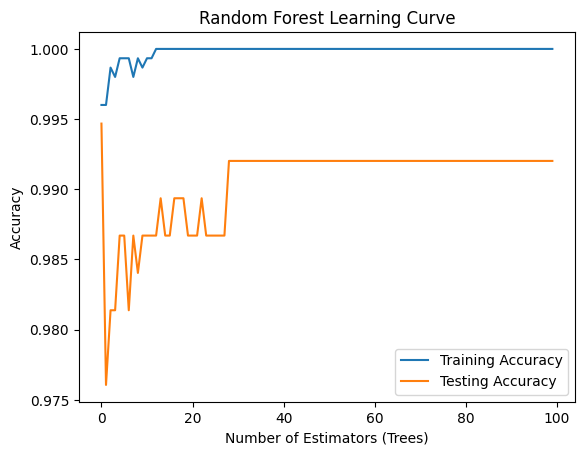

In [ ]:
# Visualize the model's learning process by plotting the training and testing accuracies

# Initialize lists to store training and testing accuracies
train_accuracies = []
test_accuracies = []

# Initialize the RandomForestClassifier
model_trees_optim = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model with different number of estimators and calculate accuracies
for n_estimators in range(1,101):
    model_trees_optim.set_params(n_estimators=n_estimators)
    model_trees_optim.fit(X_train, y_train)

    # Calculate accuracy on training set
    train_accuracy = model_trees_optim.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Calculate accuracy on testing set
    test_accuracy = model_trees_optim.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

# Plot learning curve
plt.figure()
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy')
plt.title('Random Forest Learning Curve')
plt.legend()
plt.show()

# Features importance

In [ ]:
# Name of features

# Convert numpy array 'X' to a pandas DataFrame
X_df = pd.DataFrame(X)

# Obtain a list with the name of the features
feature_names = X_df.columns.tolist()
print(feature_names)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

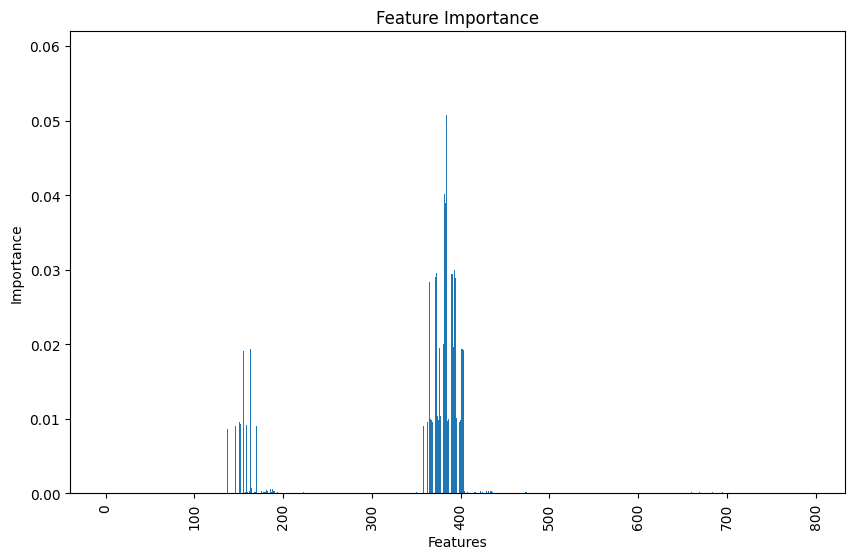

In [ ]:
# Calculate the importance of features
feature_importance = model.feature_importances_

# Create a dataframe with feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Plot the most important features in a bar plot
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Sort the dataframe by feature importance
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(sorted_feature_importance_df.head(30))

NameError: name 'feature_importance_df' is not defined